# Sohil Parsana-solution

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
os.chdir("/content/drive/My Drive/Data/infrrd")

## 1. Loading the train data

In [3]:
train_data = pd.read_csv("train.txt", sep="\t", header=None,names=["Name", "Tag"])
train_data

,Name,Tag
0,@paulwalk,O
1,It,O
2,'s,O
3,the,O
4,view,O
...,...,...
57888,39,O
57889,GMT+0000,O
57890,(,O
57891,UTC,O


In [4]:
train_data.describe()

,Name,Tag
count,55725,55731
unique,13794,13
top,.,O
freq,1777,53003


## 2. Exploratory data analysis

### NaN

In [5]:
## Checking NA
train_data.isnull().sum()

Name    2168
Tag     2162
dtype: int64

In [6]:
##Check unique entities
set(train_data['Tag'])

{'B-corporation',
 'B-creative-work',
 'B-group',
 'B-location',
 'B-person',
 'B-product',
 'I-corporation',
 'I-creative-work',
 'I-group',
 'I-location',
 'I-person',
 'I-product',
 'O',
 nan}

In [7]:
##investigate Na behavior
name_na=train_data[train_data['Name'].isnull()]
tag_na=train_data[train_data['Tag'].isnull()]

In [8]:
set(name_na['Tag'])

{'O', nan}

In [9]:
## Checking tags
name_na[~name_na['Tag'].isnull()]

,Name,Tag
55605,NaN,O
55606,NaN,O
55615,NaN,O
55616,NaN,O
56622,NaN,O
57688,NaN,O


In [10]:
## Drop Na
train_data = train_data.dropna()
train_data.shape

(55725, 2)

### Exploring entity labels

In [11]:
tags = train_data.Tag.value_counts().reset_index().values.tolist()
tags

[['O', 52997],
 ['B-person', 566],
 ['B-location', 494],
 ['I-person', 288],
 ['B-group', 230],
 ['I-location', 226],
 ['B-corporation', 196],
 ['I-product', 163],
 ['I-creative-work', 150],
 ['I-group', 132],
 ['B-product', 130],
 ['B-creative-work', 110],
 ['I-corporation', 43]]

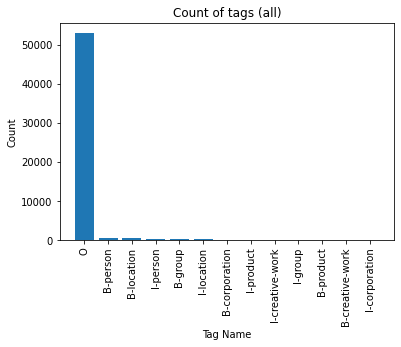

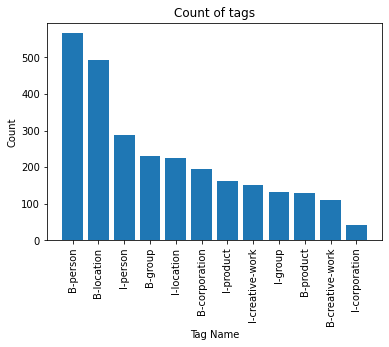

In [12]:
vals = [i[0] for i in tags]
counts = [i[1] for i in tags]
plt.bar(range(0,len(vals)),counts)
plt.xticks(range(0,len(vals)), vals, rotation='vertical')
plt.xlabel("Tag Name")
plt.ylabel("Count")
plt.title('Count of tags (all)')
plt.show()
plt.bar(range(0,len(vals)-1),counts[1:])
plt.xticks(range(0,len(vals)-1), vals[1:], rotation='vertical')
plt.xlabel("Tag Name")
plt.ylabel("Count")
plt.title('Count of tags')
plt.show()

In [13]:
import re
 
def shape(word):
    word_shape = 'other'
    if re.match('[0-9]+(\.[0-9]*)?|[0-9]*\.[0-9]+$', word):
        word_shape = 'number'
    elif re.match('\W+$', word):
        word_shape = 'punct'
    elif re.match('[A-Z][a-z]+$', word):
        word_shape = 'capitalized'
    elif re.match('[A-Z]+$', word):
        word_shape = 'uppercase'
    elif re.match('[a-z]+$', word):
        word_shape = 'lowercase'
    if re.compile(r'^http[s]?://').match(word):
        word_shape = "URLs"
    elif re.match('[A-Za-z]+$', word):
        word_shape = 'mixedcase'
    elif re.match('__.+__$', word):
        word_shape = 'wildcard'
    elif re.match('[A-Za-z0-9]+\.$', word):
        word_shape = 'ending-dot'
    elif re.match('[A-Za-z0-9]+\.[A-Za-z0-9\.]+\.$', word):
        word_shape = 'abbreviation'
    elif re.match('[A-Za-z0-9]+\-[A-Za-z0-9\-]+.*$', word):
        word_shape = 'contains-hyphen'
 
    return word_shape

In [14]:
## Various count types
word_type=train_data['Name'].apply(lambda x:shape(str(x)))
word_type.value_counts()

mixedcase          41361
punct               7122
other               4551
number              1630
URLs                 859
contains-hyphen      185
abbreviation          17
Name: Name, dtype: int64

Upon reading about entity recognition, I assume B stands for Beginning, I for Inside and and O for Outside. It is seen that O vastly outnumbers other tags

In [ ]:
## Make sentences from corpora
k=0
sent_number=[]
for i in range(train_data.shape[0]):
  sent_number.append("Sentence: {}".format(k))
  if re.match(r"[\?|!|\.]", str(train_data.iloc[i,0])) is not None:
    k=k+1
  

## 3. Baselines

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
X = train_data.drop('Tag', axis=1)
v = DictVectorizer(sparse=False)
X = v.fit_transform(X.to_dict('records'))
y = train_data.Tag.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)

(44580, 13794) (44580,)


In [8]:
dict_words=list(set(y))

### Perceptron

I selected perceptron as a baseline to for the task. It is simplest NN but can be very effective for multiclass classification.

In [9]:
base1 = Perceptron(verbose=10, n_jobs=-1, max_iter=3)
base1.partial_fit(X_train, y_train, dict_words)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 10.91, NNZs: 110, Bias: -1.000000, T: 44580, Avg. loss: 0.002266
Total training time: 1.16 seconds.
-- Epoch 1
Norm: 15.46, NNZs: 191, Bias: -1.000000, T: 44580, Avg. loss: 0.002355
Total training time: 1.28 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s


Norm: 18.30, NNZs: 295, Bias: -1.000000, T: 44580, Avg. loss: 0.004778
Total training time: 1.23 seconds.
-- Epoch 1
Norm: 28.07, NNZs: 633, Bias: -2.000000, T: 44580, Avg. loss: 0.009107
Total training time: 1.20 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s


Norm: 28.91, NNZs: 693, Bias: -2.000000, T: 44580, Avg. loss: 0.009107
Total training time: 1.30 seconds.
-- Epoch 1
Norm: 13.67, NNZs: 169, Bias: -1.000000, T: 44580, Avg. loss: 0.002355
Total training time: 1.24 seconds.
-- Epoch 1
Norm: 7.62, NNZs: 55, Bias: -2.000000, T: 44580, Avg. loss: 0.000920
Total training time: 1.22 seconds.
-- Epoch 1
Norm: 11.36, NNZs: 117, Bias: -1.000000, T: 44580, Avg. loss: 0.003858
Total training time: 1.24 seconds.
-- Epoch 1
Norm: 12.00, NNZs: 129, Bias: -2.000000, T: 44580, Avg. loss: 0.003185
Total training time: 1.24 seconds.
-- Epoch 1
Norm: 16.52, NNZs: 244, Bias: -1.000000, T: 44580, Avg. loss: 0.004621
Total training time: 1.26 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s


Norm: 20.32, NNZs: 357, Bias: -1.000000, T: 44580, Avg. loss: 0.005428
Total training time: 1.17 seconds.
-- Epoch 1
Norm: 14.56, NNZs: 180, Bias: -2.000000, T: 44580, Avg. loss: 0.003544
Total training time: 1.20 seconds.
Norm: 62.06, NNZs: 3074, Bias: 1.000000, T: 44580, Avg. loss: 0.046635
Total training time: 1.20 seconds.


[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    8.6s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=3, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=10, warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score
dict_words.pop()
print(accuracy_score(y_pred=base1.predict(X_test), y_true=y_test))
print(classification_report(y_pred=base1.predict(X_test), y_true=y_test, labels=dict_words))

0.9539703903095559
                 precision    recall  f1-score   support

  I-corporation       0.00      0.00      0.00         8
I-creative-work       0.33      0.06      0.11        32
       B-person       0.73      0.10      0.17       112
        B-group       0.58      0.19      0.29        37
              O       0.96      0.99      0.98     10605
        I-group       0.00      0.00      0.00        25
  B-corporation       0.28      0.47      0.35        53

      micro avg       0.96      0.97      0.96     10872
      macro avg       0.41      0.26      0.27     10872
   weighted avg       0.95      0.97      0.96     10872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Fined tuned BERT

BERT is a model that broke several records for how well models can handle language-based tasks. Using this model is great cause firstly is would be a general purpose model that could be used for other NLP tasks based on the given dataset. Since BERT is available as a multilingual model in 102 languages, you can use it for a wide variety of tasks. Also, it leverages the power of already pretrained weights trained on diverse corpora.

In [ ]:
import nltk
import numpy as np
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
## Getting POS tags
train_data_list = train_data.values.tolist()
tagged = []
for i, doc in enumerate(train_data_list):
    docs = [(doc[0],doc[1])]
    tokens = [doc[0]]
    tagged.append(nltk.pos_tag(str(tokens)))

In [ ]:
train_data['Sentence #']=sent_number
train_data['POS']=tagged

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_data

,Name,Tag,Sentence #,POS
0,@paulwalk,O,Sentence: 0,"[([, NN), (', ''), (@, JJ), (p, IN), (a, DT), ..."
1,It,O,Sentence: 0,"[([, NN), (', ''), (I, PRP), (t, VBP), (', '')..."
2,'s,O,Sentence: 0,"[([, JJ), ("", NNP), (', POS), (s, NN), ("", CD)..."
3,the,O,Sentence: 0,"[([, NN), (', ''), (t, JJ), (h, NN), (e, NN), ..."
4,view,O,Sentence: 0,"[([, NN), (', ''), (v, NN), (i, NN), (e, VBP),..."
...,...,...,...,...
57888,39,O,Sentence: 3888,"[([, NN), (', POS), (3, CD), (9, CD), (', POS)..."
57889,GMT+0000,O,Sentence: 3888,"[([, NN), (', ''), (G, NNP), (M, NNP), (T, NNP..."
57890,(,O,Sentence: 3888,"[([, NN), (', ''), ((, (), (', POS), (], NN)]"
57891,UTC,O,Sentence: 3888,"[([, NN), (', ''), (U, NNP), (T, NNP), (C, NNP..."


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Name"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(train_data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['@paulwalk',
 'It',
 "'s",
 'the',
 'view',
 'from',
 'where',
 'I',
 "'m",
 'living',
 'for',
 'two',
 'weeks',
 '.']

In [ ]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(train_data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

### Apply BERT

Operations to tokenize and convert the input for fine-tuning the BERT model

In [ ]:
!pip install transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
MAX_LEN = 75 #Limit 512
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)


'Tesla T4'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

### Setup BERT

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Fit BERT

In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
from tqdm import trange
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.3134572689174389


Epoch:  25%|██▌       | 1/4 [00:41<02:05, 41.93s/it]

Validation loss: 0.17481704592704772
Validation Accuracy: 0.9614517121181054
Validation F1-Score: 0.07054673721340388

Average train loss: 0.17047558418874229


Epoch:  50%|█████     | 2/4 [01:25<01:24, 42.37s/it]

Validation loss: 0.14098909467458726
Validation Accuracy: 0.9658601599343859
Validation F1-Score: 0.3206459054209919

Average train loss: 0.1175975705668026


Epoch:  75%|███████▌  | 3/4 [02:09<00:43, 43.05s/it]

Validation loss: 0.1405012544989586
Validation Accuracy: 0.9669366413778963
Validation F1-Score: 0.35984095427435386

Average train loss: 0.09087759279170815


Epoch: 100%|██████████| 4/4 [02:55<00:00, 43.98s/it]

Validation loss: 0.14611064299941062
Validation Accuracy: 0.9664240311667008
Validation F1-Score: 0.381651376146789



We see that we get a higher accuracy and a decent F-1 score than our baseline

In [ ]:
torch.save(model.state_dict(), 'bert.pth')

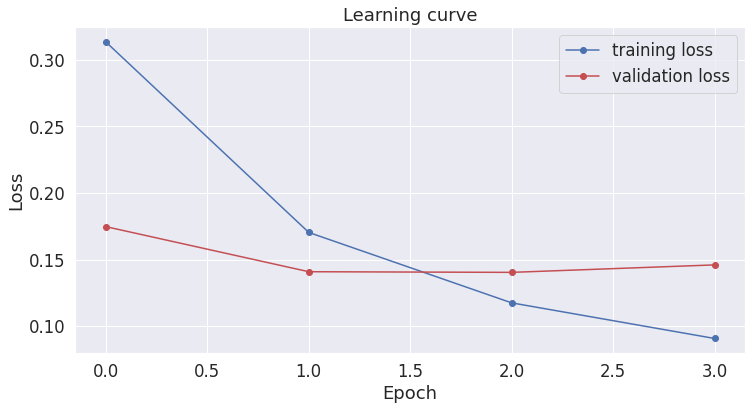

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [334]:
## preparing and predicting from test data
def prepare_data(test):
  sent_number=[]
  sentences=[]
  for i in range(test.shape[0]):
    sent_number.append(test.iloc[i]['Name'])
    if (re.match(r"[\?|!|\.]", str(test.iloc[i]['Name'])) is not None) and sent_number!=' ':
      sentences.append(sent_number)
      sent_number=[]
  new_tokens, new_labels,p = [], [], []
  for sentence in sentences:
    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    for i in range(1,len(output[0][0])-1):
      p.append(torch.topk(torch.nn.functional.softmax(output[0][0][i]).data,1)[0].to('cpu').numpy()[0])
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    for token, label_idx in zip(sentence, label_indices[0][1:-1]):
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)   

  return pd.DataFrame({'Name': new_tokens,'Label':new_labels, 'Probability':p })

In [ ]:
import csv
test = pd.read_csv("test.txt", sep="\t", header=None,names=["Name"],quoting=csv.QUOTE_NONE,encoding='utf-8')
test = test.dropna()

In [ ]:
test.shape

(23393, 1)

In [335]:
result=prepare_data(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [340]:
result.to_csv("submisison.txt", sep='\t', encoding='utf-8', index=False)

We have results as the predicted tag for each entity along with the probability measure which gives us an estimate of confidence the model has on the predicted label. The model can be used for transfer learning to different applications based on this data set.
